In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import sympy as smp
from matplotlib import animation
from matplotlib.animation import PillowWriter

A diagram of the problem at hand:

* The entire system depends on the position of the center of gravity $x$ and the angle $\theta$
* We will use these variables as our free variables

<p align="center">
  <img src="./images/molla_asta.png" alt="drawing" width="300" align="center"/>
</p>

Define all symbols we need for this problem using sympy:

In [3]:
t, L0, m, k , I = smp.symbols('t L0 m k I')
x, the = smp.symbols(r'x \theta', cls=smp.Function)

Define $x(t)$ and $\dot{x}(t)$ and $\ddot{x}(t)$
<br>
Define $\theta(t)$ and $\dot{\theta}(t)$ and $\ddot{\theta}(t)$

In [4]:
x = x(t)
the = the(t)
x_d = smp.diff(x, t)
the_d = smp.diff(the, t)
x_dd = smp.diff(x_d, t)
the_dd = smp.diff(the_d, t)

Define the $x$ and $\theta$ coordinates of all three masses

In [ ]:
# x1 = l1*smp.cos(the1)
# y1 = -l1*smp.sin(the1)
# x2 = 2*x1
# y2 = 0
# x3 = x2 + l2*smp.sin(the2)
# y3 = -l2*smp.cos(the2)

Define both kinetic and potential energy:

* Kinetic energy $T$ comes from the motion of the three masses
* Potential energy $V$ comes from both the gravitational potential energy of the masses $mgy$ and the potential energy in the spring $\frac{1}{2}kx^2$ where $x=x_2 - L_0$

In [5]:
T = smp.Rational(1,2) * m * smp.diff(x,t)**2 \
    +smp.Rational(1,2) * I * smp.diff(the,t)**2

V = smp.Rational(1,2) * k * x**2
L =T-V

Now we can look at the Lagrangian

In [6]:
L

I*Derivative(\theta(t), t)**2/2 - k*x(t)**2/2 + m*Derivative(x(t), t)**2/2

Get Lagrange's equations

$$\frac{\partial L}{\partial \theta} - \frac{d}{dt}\frac{\partial L}{\partial \dot{\theta}} = 0$$
$$\frac{\partial L}{\partial x} - \frac{d}{dt}\frac{\partial L}{\partial \dot{x}} = 0$$

In [7]:
LE1 = smp.diff(L, x) - smp.diff(smp.diff(L, x_d), t).simplify()
LE2 = smp.diff(L, the) - smp.diff(smp.diff(L, the_d), t).simplify()


In [67]:
LE1

-k*x(t) - m*Derivative(x(t), (t, 2))

In [68]:
LE2

-I*Derivative(\theta(t), (t, 2))

Solve Lagranges equations (this assumes that `LE1` and `LE2` are both equal to zero)

* We solve these equations (which are **linear** in $\ddot{x}$ and $\ddot{\theta}$) for $\ddot{x}$ and $\ddot{\theta_1}$.

In [8]:
sols = smp.solve([LE1, LE2], (x_dd, the_dd),
                simplify=False, rational=False)

Now we have 

* $\frac{d^2 x}{dt^2} = ...$
* $\frac{d^2 \theta}{dt^2} = ...$

These are two second order ODEs! In python we can only solve systems of first order ODEs. Any system of second order ODEs can be converted as follows:

1. Define $z_1 = d x/dt$ and $z_2=d\theta/dt$
2. Then $dz_1/dt = d^2 x/dt^2$ and $dz_2/dt = d^2\theta/dt^2$

Now we get a system of 4 first order ODEs (as opposed to 2 second order ones)

* $d z_1/dt = ...$
* $dx /dt = z_1$
* $d z_2/dt = ...$
* $d\theta/dt = z_1$

We need to convert the **symbolic** expressions above to numerical functions so we can use them in a numerical python solver. For this we use `smp.lambdify`

In [9]:

dz1dt_f = smp.lambdify((t, m, k, I, x, the, x_d, the_d), sols[x_dd])
dz2dt_f = smp.lambdify((t, m, k, I, x, the, x_d, the_d), sols[the_dd])
dxdt_f = smp.lambdify(x_d, x_d)
dthedt_f = smp.lambdify(the_d, the_d)

Now define $\vec{S} = (x, z_1, \theta, z_2)$. IF we're going to use an ODE solver in python, we need to write a function that takes in $\vec{S}$ and $t$ and returns $d\vec{S}/dt$. In other words, we need to define $d\vec{S}/dt (\vec{S}, t)$

* Our system of ODEs can be fully specified using $d\vec{S}/dt$ and depends only on $\vec{S}$ and $t$

In [10]:
def dSdt(S, t, m, k, I):
    x, z1, the, z2 = S
    return [
        dxdt_f(z1),
        dz1dt_f(t, m, k, I,x,the,z1,z2),
        dthedt_f(z2),
        dz2dt_f(t, m, k, I,x,the,z1,z2),
    ]

Solve the system of ODEs using scipys `odeint` method

In [11]:
#initial conditions
t = np.linspace(0, 40, 1001) # s
k = 30 # N/m
m=2 # kg
L0 = 1 #m
L= 1 #m lenght of the bar
I = 1/12 * m * L**2

ans = odeint(dSdt, y0=[1, -8, -1, 1], t=t, args=(m, k, I))

25 times per second (number of data points). This will be important for animating later on.

Can obtain $x(t)$ and $\theta(t)$ from the answer

In [13]:
x = ans.T[0]
the = ans.T[1]

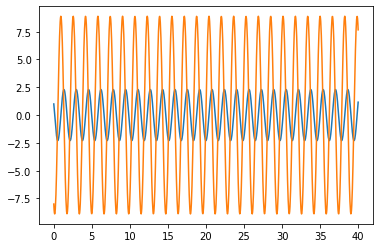

In [14]:
plt.plot(t, x)
plt.plot(t, the)

Here's a function that takes in $\theta_1$ and $\theta_2$ and returns the location (x,y) of the three masses. This will be used for animation

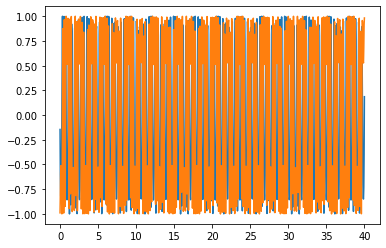

In [15]:
def get_x1y1(t, x, the, l0):
    return (l0*np.cos(the),
            l0*np.sin(the),
            L0 + x
        )
l0 = 1#m
x1, y1, xm = get_x1y1(t,ans.T[0], ans.T[1], l0)

plt.plot(t,x1)
plt.plot(t,y1)

Here is the code for a simple animation

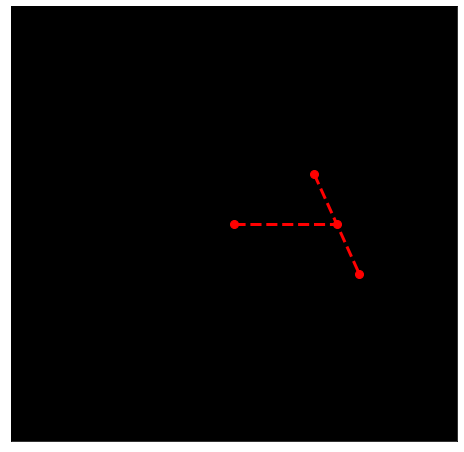

In [16]:
def animate(i):
    ln1.set_data([0, xm[i]], [0, 0])
    ln2.set_data([ xm[i] + x1[i], xm[i] - x1[i]], [y1[i], -y1[i]])
    
fig, ax = plt.subplots(1,1, figsize=(8,8))
ax.set_facecolor('k')
ax.get_xaxis().set_ticks([])    # enable this to hide x axis ticks
ax.get_yaxis().set_ticks([])    # enable this to hide y axis ticks
ln1, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ln2, = plt.plot([], [], 'ro--', lw=3, markersize=8)
ax.set_ylim(-4,4)
ax.set_xlim(-4,4)
ani = animation.FuncAnimation(fig, animate, frames=1000, interval=50)
ani.save('molla_asta.gif',writer='pillow',fps=25)